## Model Training 

Adapted from [this tutorial](https://www.tensorflow.org/tutorials/load_data/images) and [this tutorial](https://www.tensorflow.org/api_docs/python/tf/keras/Model)

This notebook is for training or retraining a model based on a curated set of glyph images. 

In [55]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import PIL
from PIL import Image
import tensorflow as tf

from tensorflow import keras
from keras import layers
from keras.models import Sequential

import pathlib
import random
import os

Set up a pathlib object pointing to the directory full of training images. 

In [56]:
data_dir = "C:/csci490/images/glyph/labeled"
data_dir = pathlib.Path(data_dir)
data_dir

WindowsPath('C:/csci490/images/glyph/labeled')

Set the batch size and image size.  
At first I used a batch size of 640 (thinking to use 40 per class per batch), but then I went back to the default of 32 after reading about the tradeoff between accuracy and training time [here](https://wandb.ai/ayush-thakur/dl-question-bank/reports/What-s-the-Optimal-Batch-Size-to-Train-a-Neural-Network---VmlldzoyMDkyNDU).

In [70]:
# batch_size = 32 # Recommended default. Larger tends to perform worse
batch_size = 512 # Literally sabotaging it so it isn't >99% accurate on epoch 1
img_height = 64
img_width = 64

Generate the training data from the folder of images.

In [71]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 5719 files belonging to 17 classes.
Using 4576 files for training.


Generate validation set from folder of images.

In [72]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 5719 files belonging to 17 classes.
Using 1143 files for validation.


17 classes includes an additional class 'u' to hopefully catch non-glyphs rather than having these end up in random folders.

In [60]:
class_names = train_ds.class_names
print(class_names)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'u']


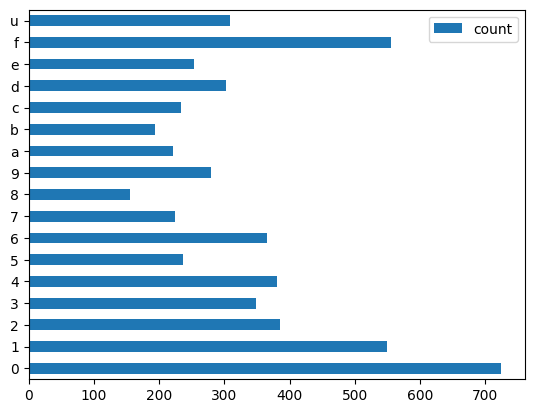

In [61]:
glyphs_dir = "C:\\csci490\\images\\glyph\\labeled"
glyphs_dirs = os.listdir(glyphs_dir)
training_counts = {}
for dir in glyphs_dirs:
    count = 0
    subdirs = os.listdir(glyphs_dir + "\\" + dir)
    for file in subdirs:
        count += 1
    # print(dir, ": ", count)
    training_counts[dir] = count

train_count_df = pd.DataFrame.from_dict(training_counts, orient='index', columns=['count'])

train_count_df

ax = train_count_df.plot.barh()


Our training data is not balanced, but these glyphs are very consistent so I don't expect this to be a serious issue. 

The increased quantity of lower numbered glyphs are likely due to the inherently low value of the planet index, which only goes up to 6 and may only go up to two for some systems. 

The increased glyph count on the higher side (toward 16) is likely due to travelers starting near the outer edge of galaxies. 

Sample of images from the training set.

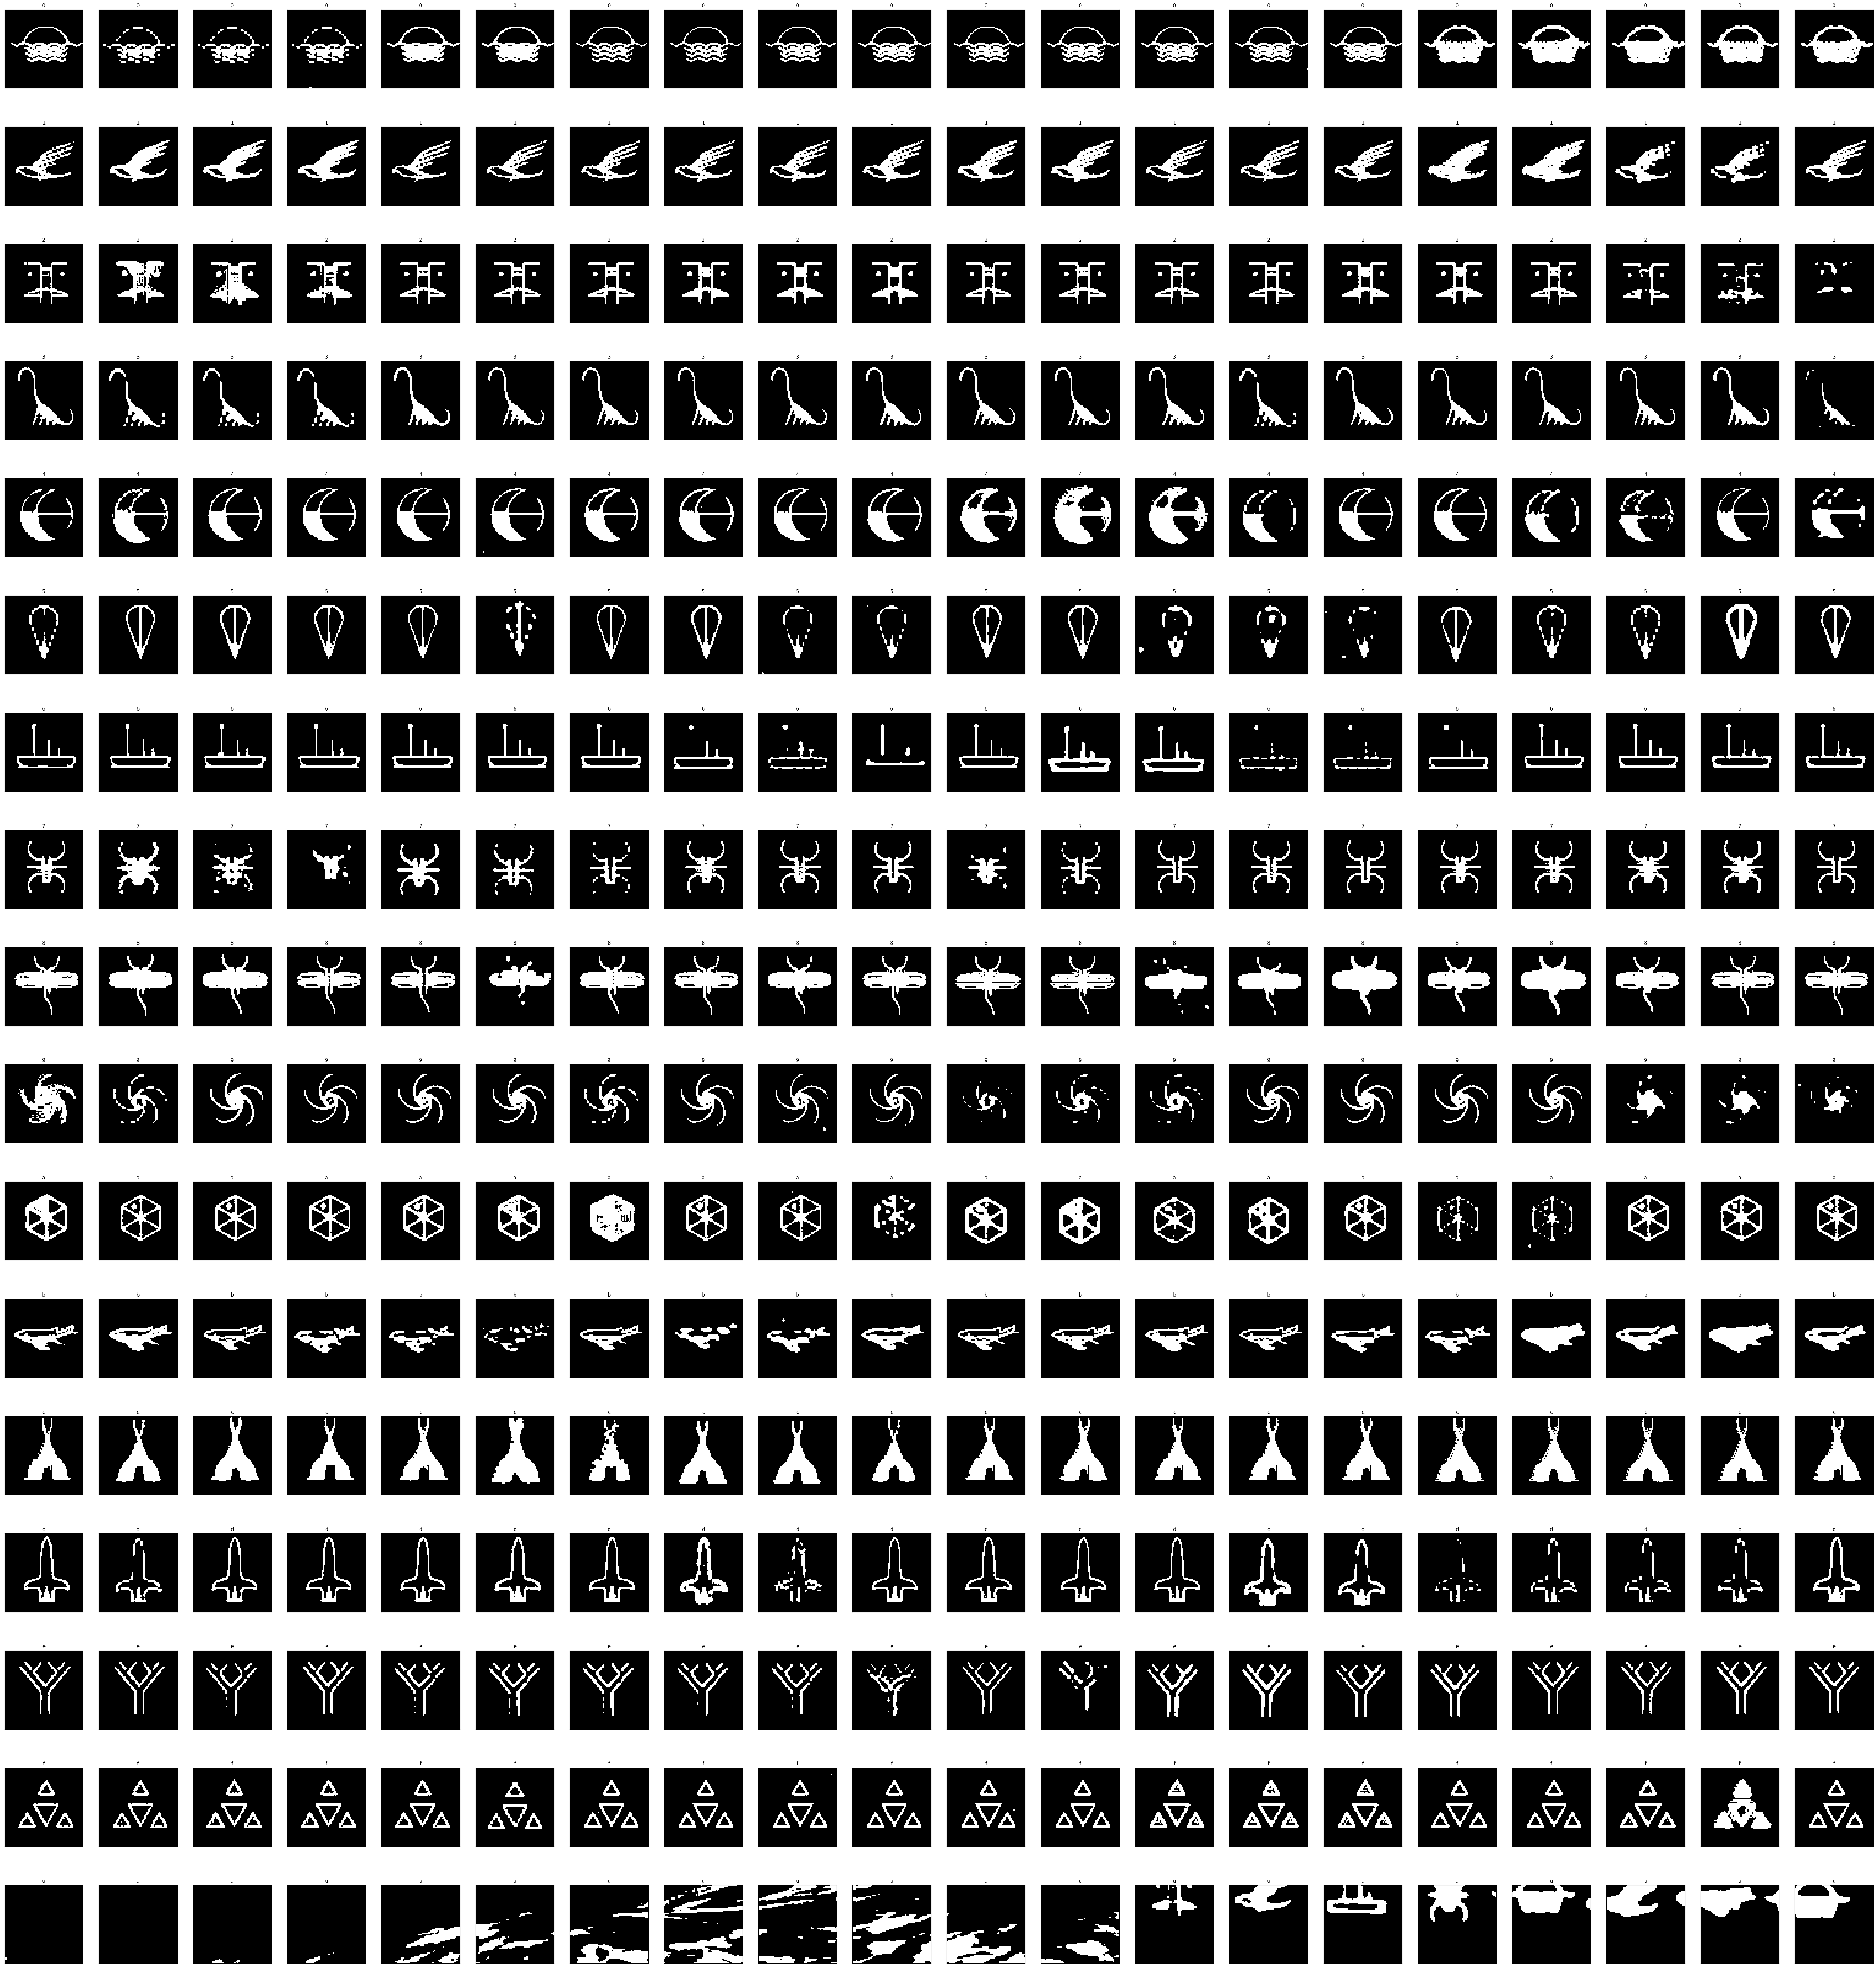

In [62]:
# Display some images
num_cols = 20
num_rows = 17
fig, axes = plt.subplots(ncols=num_cols, nrows=num_rows, sharex=True, sharey=True, figsize=(num_cols*4, num_rows*5))
glyphs_dir = "C:\\csci490\\images\\glyph\\labeled"
glyphs_subdirs = os.listdir(glyphs_dir)

for row in range(num_rows):
    subdir = glyphs_subdirs[row]
    glyph_imgs = os.listdir(glyphs_dir + "\\" + subdir)
    for i in range(num_cols):
        path = glyphs_dir + "\\" + subdir + "\\" + glyph_imgs[i]
        im = Image.open(path)
        im_array = np.asarray(im)
        axes[row][i].set_title(str(subdir))
        axes[row][i].imshow(im_array, cmap='gray')
        axes[row][i].get_xaxis().set_visible(False)
        axes[row][i].get_yaxis().set_visible(False)
plt.show()

In [63]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 64, 64, 3)
(32,)


Configure the dataset for performance

In [73]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Create model

In [74]:
num_classes = len(class_names)

model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes)
])

Compile Model

In [75]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

Train Model

In [76]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/10
9/9 [==============================] - 9s 834ms/step - loss: 2.0391 - accuracy: 0.4867 - val_loss: 0.8459 - val_accuracy: 0.8451
Epoch 2/10
9/9 [==============================] - 7s 773ms/step - loss: 0.2843 - accuracy: 0.9528 - val_loss: 0.0799 - val_accuracy: 0.9816
Epoch 3/10
9/9 [==============================] - 7s 812ms/step - loss: 0.0540 - accuracy: 0.9906 - val_loss: 0.0296 - val_accuracy: 0.9939
Epoch 4/10
9/9 [==============================] - 7s 813ms/step - loss: 0.0358 - accuracy: 0.9913 - val_loss: 0.0259 - val_accuracy: 0.9930
Epoch 5/10
9/9 [==============================] - 7s 834ms/step - loss: 0.0166 - accuracy: 0.9958 - val_loss: 0.0117 - val_accuracy: 0.9939
Epoch 6/10
9/9 [==============================] - 7s 798ms/step - loss: 0.0186 - accuracy: 0.9963 - val_loss: 0.0076 - val_accuracy: 0.9983
Epoch 7/10
9/9 [==============================] - 7s 831ms/step - loss: 0.0134 - accuracy: 0.9963 - val_loss: 0.0086 - val_accuracy: 0.9983
Epoch 8/10
9/9 [====

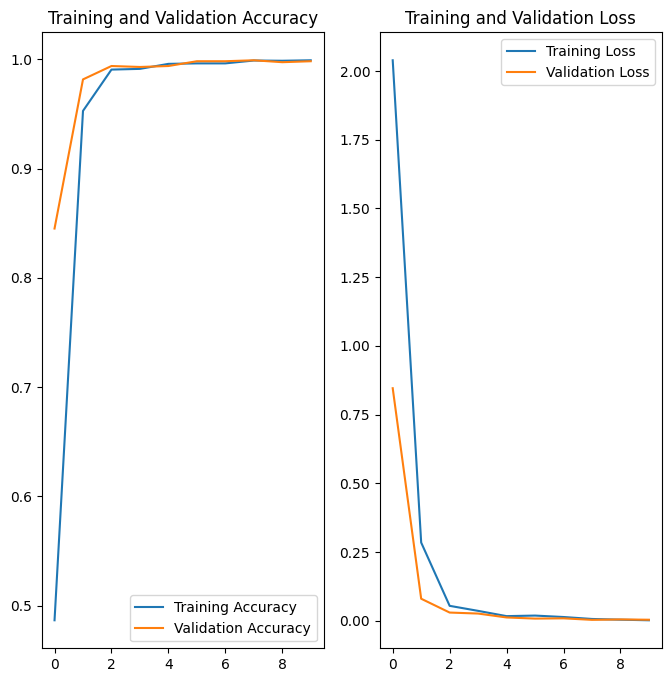

In [77]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Save Model

In [80]:
model.save('models/glyphs_17')

INFO:tensorflow:Assets written to: models/glyphs_17\assets


INFO:tensorflow:Assets written to: models/glyphs_17\assets
